### some statistics of the gbyk experiment

click [here](https://www.notion.so/in-progress-some-statistics-of-the-gbyk-experiment-17ca2d01e2ff80b28fa1e28899d36bd3?pvs=25) to access the corresponding notion page.

In [1]:
import os

from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yaml

import motorlab as ml

In [2]:
os.chdir(Path().resolve().parent)

In [3]:
sns.set_context("poster", font_scale=2.0)
sns.set_style("white")
sns.set_theme(style="ticks")

### histogram of trial duration

In [4]:
sessions = ml.config.gbyk_sessions
trial_start = {session: [] for session in sessions}
trial_end = {session: [] for session in sessions}
choice = {session: [] for session in sessions}
reward = {session: [] for session in sessions}
trial_type = {session: [] for session in sessions}
com_dict = {session: [] for session in sessions}
data_dir = Path("data/gbyk")

for session in sessions:
    trials_dir = data_dir / session / "trials"
    for trial in sorted(trials_dir.iterdir()):
        with trial.open("r") as f:
            meta = yaml.safe_load(f)

        trial_type[session].append(meta["type"])
        choice[session].append(meta["choice"])
        reward[session].append(meta["reward"])
        start = meta["first_frame_idx"]
        end = start + meta["num_frames"]
        duration = end - start
        remainder = duration % 50
        idxs_adjustment = remainder != 0
        adjustment = np.where(idxs_adjustment, remainder, 0)
        start_adjustment = adjustment // 2
        end_adjustment = adjustment - start_adjustment
        trial_start[session].append(int(start + start_adjustment))
        trial_end[session].append(int(end - end_adjustment))

    poses_dir = data_dir / session / "poses"
    with open(poses_dir / "meta" / "com.npy", "rb") as f:
        com = np.load(f)
        com_dict[session] = [
            com[s // 10 : e // 10, :].reshape((e - s) // 50, 5, 3).mean(axis=1)
            for s, e in zip(trial_start[session], trial_end[session])
        ]

In [18]:
df = pd.DataFrame(
    {
        "session": sessions,
        "trial_start": [trial_start[s] for s in sessions],
        "trial_end": [trial_end[s] for s in sessions],
        "choice": [choice[s] for s in sessions],
        "type": [trial_type[s] for s in sessions],
    }
)

df = df.explode(["trial_start", "trial_end", "choice", "type"]).reset_index(
    drop=True
)
df["duration"] = (df["trial_end"] - df["trial_start"]) / 1000

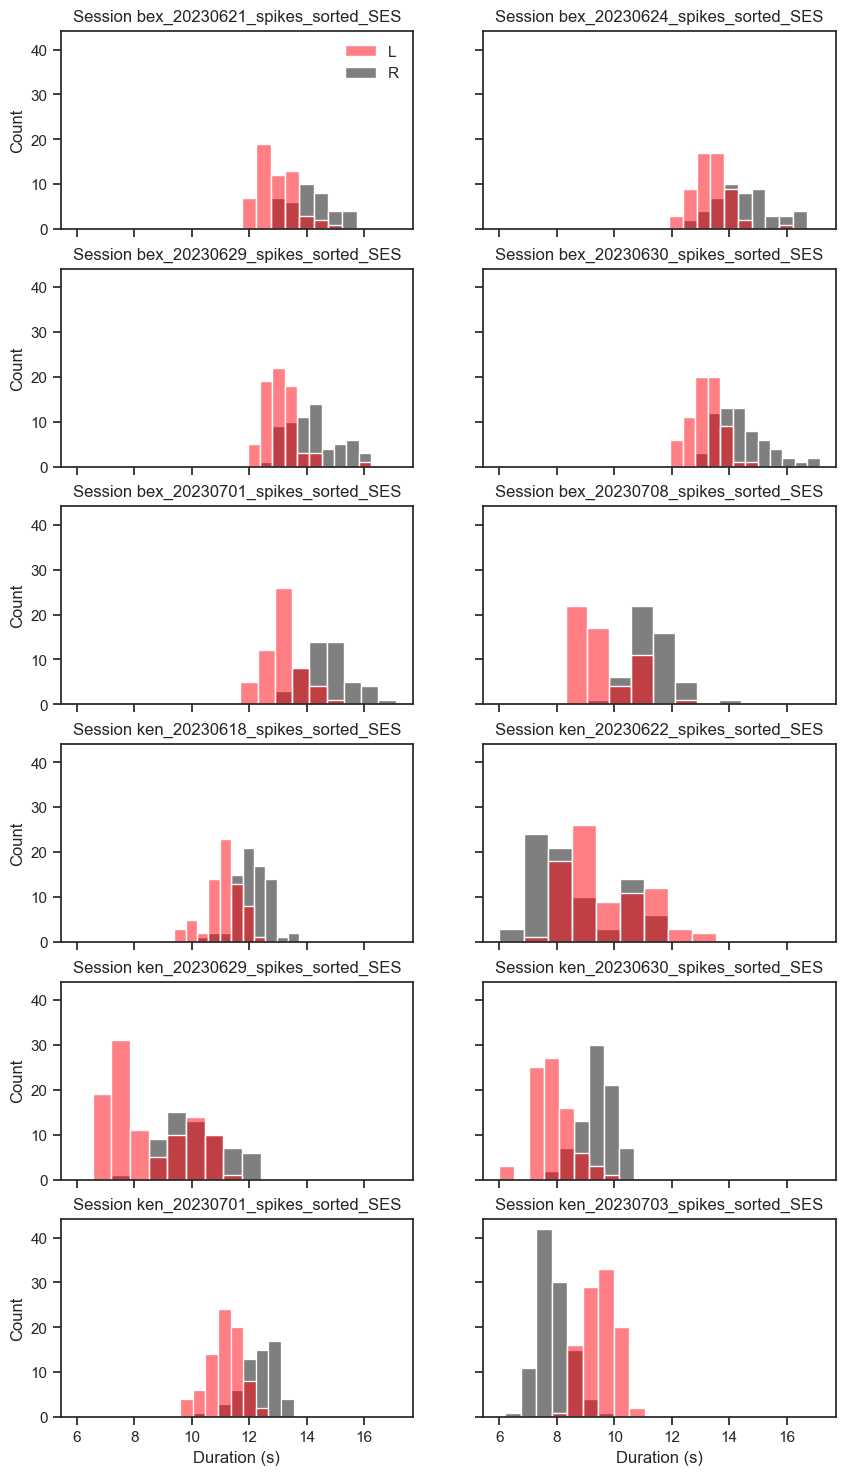

In [7]:
ncols = 2
nrows = len(sessions) // ncols + (len(sessions) % ncols > 0)
fig, axs = plt.subplots(
    nrows,
    ncols,
    figsize=(5 * ncols, 3 * nrows),
    sharex=True,
    sharey=True,
)
palette = sns.color_palette([sns.xkcd_rgb["bright red"], sns.xkcd_rgb["black"]])

for i, session in enumerate(sessions):
    session_df = df[df["session"] == session]
    if i == 0:
        g = sns.histplot(
            session_df,
            x="duration",
            hue="choice",
            ax=axs[i // ncols, i % ncols],
            palette=palette,
            legend=True,
        )
    else:
        sns.histplot(
            session_df,
            x="duration",
            hue="choice",
            ax=axs[i // ncols, i % ncols],
            palette=palette,
            legend=False,
        )
    axs[i // ncols, i % ncols].set_title(f"Session {session}", pad=7)
    axs[i // ncols, i % ncols].set_xlabel("Duration (s)")


g.legend_.set_title("")
g.legend_.set_frame_on(False)
plt.savefig(
    f"plots/gbyk_stats/histogram_duration.svg",
    format="svg",
    bbox_inches="tight",
)
plt.show()

### trials stats

In [27]:
df["type"].unique()

array(['precue', 'gbyk', 'feedback'], dtype=object)

In [30]:
summary = (
    df.groupby(["session", "choice", "type"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)
print(summary)

type                         session choice  feedback  gbyk  precue
0     bex_20230621_spikes_sorted_SES      L         0     0      57
1     bex_20230621_spikes_sorted_SES      R         0     0      39
2     bex_20230624_spikes_sorted_SES      L         0     0      58
3     bex_20230624_spikes_sorted_SES      R         0     0      50
4     bex_20230629_spikes_sorted_SES      L         0     0      71
5     bex_20230629_spikes_sorted_SES      R         0     0      63
6     bex_20230630_spikes_sorted_SES      L         0     0      68
7     bex_20230630_spikes_sorted_SES      R         0     0      64
8     bex_20230701_spikes_sorted_SES      L         0     0      56
9     bex_20230701_spikes_sorted_SES      R         0     0      49
10    bex_20230708_spikes_sorted_SES      L         0    55       0
11    bex_20230708_spikes_sorted_SES      R         0    51       0
12    ken_20230618_spikes_sorted_SES      L         0     0      69
13    ken_20230618_spikes_sorted_SES      R     

In [9]:
for session in sessions:
    for c, r, t in zip(choice[session], reward[session], trial_type[session]):
        if c != r:
            print(f"{session}, type: {t}, choice: {c}, reward: {r}")

bex_20230621_spikes_sorted_SES, type: precue, choice: L, reward: R
bex_20230621_spikes_sorted_SES, type: precue, choice: L, reward: R
bex_20230621_spikes_sorted_SES, type: precue, choice: L, reward: R
bex_20230621_spikes_sorted_SES, type: precue, choice: L, reward: R
bex_20230621_spikes_sorted_SES, type: precue, choice: L, reward: R
bex_20230621_spikes_sorted_SES, type: precue, choice: L, reward: R
bex_20230621_spikes_sorted_SES, type: precue, choice: L, reward: R
bex_20230621_spikes_sorted_SES, type: precue, choice: L, reward: R
bex_20230621_spikes_sorted_SES, type: precue, choice: L, reward: R
bex_20230624_spikes_sorted_SES, type: precue, choice: L, reward: R
bex_20230624_spikes_sorted_SES, type: precue, choice: R, reward: L
bex_20230624_spikes_sorted_SES, type: precue, choice: L, reward: R
bex_20230624_spikes_sorted_SES, type: precue, choice: L, reward: R
bex_20230624_spikes_sorted_SES, type: precue, choice: R, reward: L
bex_20230624_spikes_sorted_SES, type: precue, choice: L, rewar

### traces of the center of mass across trials

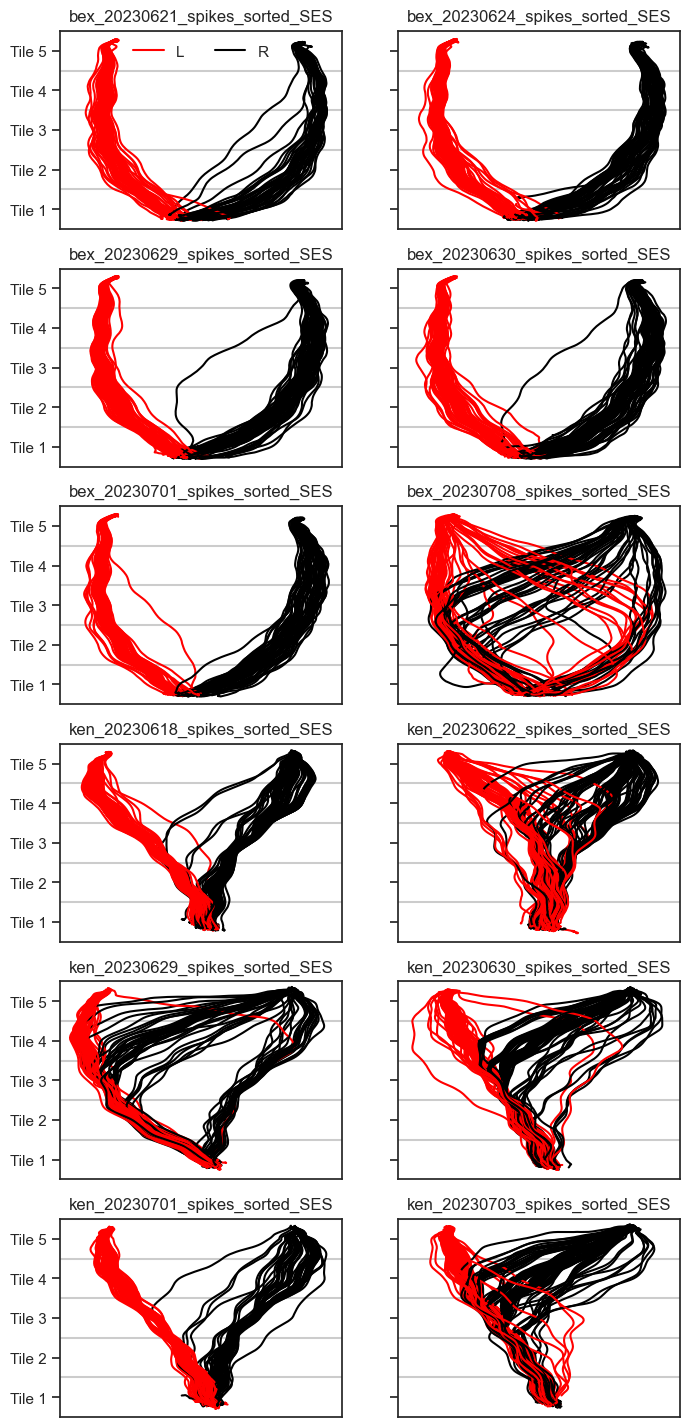

In [10]:
ncols = 2
nrows = len(sessions) // ncols + (len(sessions) % ncols > 0)
fig, axs = plt.subplots(
    nrows,
    ncols,
    figsize=(4 * ncols, 3 * nrows),
    sharex=True,
    sharey=True,
)
palette = sns.color_palette([sns.xkcd_rgb["bright red"], sns.xkcd_rgb["black"]])

tile_size = ml.room.y_size / ml.room.y_divisions
ylines = [(i + 1) * tile_size for i in range(ml.room.y_divisions)]
for i, session in enumerate(sessions):
    axs[i // ncols, i % ncols].set_title(session, pad=7)
    for y in ylines:
        axs[i // ncols, i % ncols].axhline(
            y=y, color="black", linestyle="-", alpha=0.2
        )
    for c, t in zip(choice[session], com_dict[session]):
        if c == "L":
            axs[i // ncols, i % ncols].plot(t[:, 0], t[:, 1], color="red")
        else:
            axs[i // ncols, i % ncols].plot(t[:, 0], t[:, 1], color="black")

plt.xticks([])
yticks_positions = [
    i * tile_size + tile_size / 2 for i in range(ml.room.y_divisions)
]
yticks_labels = ["Tile 1", "Tile 2", "Tile 3", "Tile 4", "Tile 5"]
axs[0, 0].set_yticks(yticks_positions)
axs[0, 0].set_yticklabels(yticks_labels)
axs[0, 0].set_ylim(0, ml.room.y_size)
axs[0, 0].set_xlim(0, ml.room.x_size)
axs[0, 0].plot([], [], color="red", label="L")
axs[0, 0].plot([], [], color="black", label="R")
axs[0, 0].legend(frameon=False, ncols=2, loc="upper center")

plt.savefig(
    "plots/gbyk_stats/traces_com.svg", format="svg", bbox_inches="tight"
)
plt.show()